Initial rows: 200000
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647         

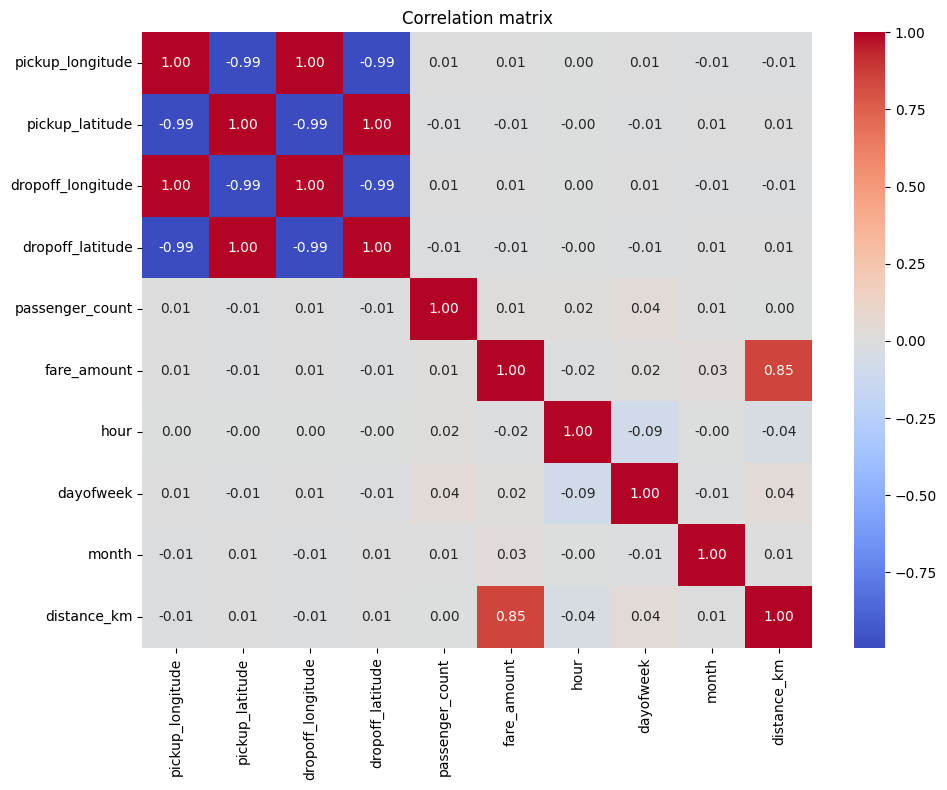


Features used: ['distance_km', 'passenger_count', 'hour', 'dayofweek', 'month']

Linear Regression results:
R2: 0.734135978518232
RMSE: 2.6335729465773374
MAE: 1.7969503273440484
LR Cross-val R2 (5-fold): mean=0.7322 std=0.0032
Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:

import os
import glob
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

# -----------------------

def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# -------------------------
# 3. Load dataset
# -------------------------
DATA_DIR = './data'
# If you've downloaded the Kaggle dataset, place extracted files into ./data

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)





df = pd.read_csv('uber.csv')
print('Initial rows:', df.shape[0])
print(df.head())

# -------------------------
# 4. Quick EDA & preprocessing
# -------------------------
# Common columns in Uber fares datasets: pickup_datetime, pickup_longitude, pickup_latitude,
# dropoff_longitude, dropoff_latitude, passenger_count, fare_amount

# Rename columns to a canonical set if necessary (safer to lowercase)
df.columns = [c.strip() for c in df.columns]

# Lowercase column names for robustness
df.columns = [c.lower() for c in df.columns]

# show columns
print('\nColumns:', df.columns.tolist())

# Keep only relevant columns if present
expected = ['pickup_datetime','pickup_longitude','pickup_latitude',
            'dropoff_longitude','dropoff_latitude','passenger_count','fare_amount']
keep_cols = [c for c in expected if c in df.columns]
if len(keep_cols) < 5:
    print('Warning: dataset columns differ from expected. Current columns will be used.')
else:
    df = df[keep_cols]

# Parse datetime
if 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    df = df.dropna(subset=['pickup_datetime'])
    df['hour'] = df['pickup_datetime'].dt.hour
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
    df['month'] = df['pickup_datetime'].dt.month

# Compute haversine distance
if set(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']).issubset(df.columns):
    df['distance_km'] = haversine_distance(df['pickup_latitude'].values,
                                          df['pickup_longitude'].values,
                                          df['dropoff_latitude'].values,
                                          df['dropoff_longitude'].values)

# Basic cleaning
# Remove fares <= 0 and distances == 0 (or extremely small)
if 'fare_amount' in df.columns:
    df = df[df['fare_amount'] > 0]

if 'distance_km' in df.columns:
    df = df[df['distance_km'] > 0.01]

# Remove unrealistic passenger counts
if 'passenger_count' in df.columns:
    df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 8)]

print('\nAfter basic cleaning, rows:', df.shape[0])

# -------------------------
# 5. Identify outliers
# -------------------------
# We'll use IQR for fare_amount and distance

def iqr_filter(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return low, high

outlier_report = {}
for col in ['fare_amount','distance_km']:
    if col in df.columns:
        low, high = iqr_filter(df[col])
        mask = (df[col] < low) | (df[col] > high)
        outlier_report[col] = {'low': low, 'high': high, 'n_outliers': mask.sum()}

print('\nOutlier report (IQR k=1.5):')
print(outlier_report)

# Option: remove extreme outliers
for col in ['fare_amount','distance_km']:
    if col in df.columns:
        low, high = iqr_filter(df[col], k=3.0)  # more permissive, keep majority
        df = df[(df[col] >= low) & (df[col] <= high)]

print('Rows after removing extreme outliers:', df.shape[0])

# -------------------------
# 6. Correlation check
# -------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric columns used for correlation:', numeric_cols)

corr = df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

# -------------------------
# 7. Feature selection / engineering
# -------------------------
# Candidate features
features = []
if 'distance_km' in df.columns:
    features.append('distance_km')
if 'passenger_count' in df.columns:
    features.append('passenger_count')
if 'hour' in df.columns:
    features.append('hour')
if 'dayofweek' in df.columns:
    features.append('dayofweek')
if 'month' in df.columns:
    features.append('month')

# add raw lat/lon if you want but can increase model complexity
# features += ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']

print('\nFeatures used:', features)

X = df[features].copy()
y = df['fare_amount'].copy()

# One-hot encoding if needed (e.g., hour as cyclical features)
# Convert hour to sin/cos to capture cyclic nature
if 'hour' in X.columns:
    X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
    X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
    X = X.drop(columns=['hour'])

# drop columns with low variance or not required

# -------------------------
# 8. Train-test split and scaling
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 9. Linear Regression
# -------------------------
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)

print('\nLinear Regression results:')
print('R2:', lr_r2)
print('RMSE:', lr_rmse)
print('MAE:', lr_mae)

# Cross-val for LR
cv_scores = cross_val_score(lr, scaler.transform(X), y, cv=5, scoring='r2')
print('LR Cross-val R2 (5-fold): mean=%.4f std=%.4f' % (cv_scores.mean(), cv_scores.std()))

# -------------------------
# 10. Random Forest Regression
# -------------------------
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# Basic grid search for a few hyperparams
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [8, 15, None],
    'min_samples_leaf': [1, 3]
}

gs = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print('\nRandom Forest best params:', gs.best_params_)
rf_best = gs.best_estimator_

y_pred_rf = rf_best.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print('\nRandom Forest results:')
print('R2:', rf_r2)
print('RMSE:', rf_rmse)
print('MAE:', rf_mae)

# Cross-val for RF
cv_scores_rf = cross_val_score(rf_best, X, y, cv=5, scoring='r2', n_jobs=-1)
print('RF Cross-val R2 (5-fold): mean=%.4f std=%.4f' % (cv_scores_rf.mean(), cv_scores_rf.std()))

# -------------------------
# 11. Compare models
# -------------------------
print('\nComparison:')
print('Model\tR2\tRMSE\tMAE')
print('LR\t{:.4f}\t{:.3f}\t{:.3f}'.format(lr_r2, lr_rmse, lr_mae))
print('RF\t{:.4f}\t{:.3f}\t{:.3f}'.format(rf_r2, rf_rmse, rf_mae))

# Residual plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_lr - y_test, alpha=0.2)
plt.axhline(0, color='red', linestyle='--')
plt.title('LR Residuals')
plt.xlabel('True fare')
plt.ylabel('Residual')

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_rf - y_test, alpha=0.2)
plt.axhline(0, color='red', linestyle='--')
plt.title('RF Residuals')
plt.xlabel('True fare')
plt.tight_layout()
plt.show()

# Feature importances from RF
if hasattr(rf_best, 'feature_importances_'):
    importances = pd.Series(rf_best.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)
    print('\nTop feature importances (RF):')
    print(importances.head(10))
    plt.figure(figsize=(6,4))
    importances.head(10).plot(kind='bar')
    plt.title('Feature importances (RF)')
    plt.tight_layout()
    plt.show()

# -------------------------
# 12. Save models and scaler
# -------------------------
joblib.dump(rf_best, 'rf_model.joblib')
joblib.dump(lr, 'lr_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

print('\nModels and scaler saved to current folder.')

# -------------------------
# 13. Notes / next steps
# -------------------------
# - Consider adding surge/zone features, weather, holidays, and traffic proxies.
# - Experiment with gradient boosting (XGBoost/LightGBM), target transformations (log), and stacking.
# - Use time-based CV (if data is temporal) instead of random splits.

# End of script
